In [1]:
%%time
%%capture captured_output
%pip install numpy==1.26
%pip install matplotlib==3.9.2
%pip install skillsnetwork

CPU times: user 5.21 s, sys: 636 ms, total: 5.84 s
Wall time: 21.4 s


In [2]:
%%time
%pip install torch==2.7.0

CPU times: user 2.22 s, sys: 293 ms, total: 2.51 s
Wall time: 13.3 s


In [3]:
%%time
%pip install torchvision==0.22

CPU times: user 2.4 s, sys: 294 ms, total: 2.69 s
Wall time: 13.9 s


In [4]:
%%time
%pip install tensorflow==2.19

CPU times: user 2.07 s, sys: 280 ms, total: 2.35 s
Wall time: 11.8 s


In [5]:
import os
import skillsnetwork

data_dir = "."
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar"


def check_skillnetwork_extraction(extract_dir):
    """Check if the environment allows symlink creation for download/extraction."""
    symlink_test = os.path.join(extract_dir, "symlink_test")
    if not os.path.exists(symlink_test):
        os.symlink(os.path.join(os.sep, "tmp"), symlink_test)
        print("Write permissions available for downloading and extracting the dataset tar file")
        os.unlink(symlink_test)

async def download_tar_dataset(url, tar_path, extract_dir):
    """Download and extract dataset tar file asynchronously."""
    if not os.path.exists(tar_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(tar_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{tar_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Dataset tar file already exists at: {tar_path}")
    import tarfile
    with tarfile.open(tar_path, 'r:*') as tar_ref:
        tar_ref.extractall(path=extract_dir)
        print(f"Successfully extracted to '{extract_dir}'.")

try:
    check_skillnetwork_extraction(data_dir)
    await skillsnetwork.prepare(url=dataset_url, path=data_dir, overwrite=True)
except Exception as e:
    print(e)
    print("Primary download/extraction method failed.")
    print("Falling back to manual download and extraction...")
    import tarfile
    import httpx
    from pathlib import Path
    file_name = Path(dataset_url).name
    tar_path = os.path.join(data_dir, file_name)
    await download_tar_dataset(dataset_url, tar_path, data_dir)

Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


In [6]:
!pip install --upgrade numpy

  Using cached numpy-2.4.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)
Using cached numpy-2.4.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.4.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.4.2 which is incompatible.


In [1]:
%%time
import warnings
warnings.filterwarnings('ignore')

import os
import time
import httpx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

CPU times: user 107 ms, sys: 13.2 ms, total: 120 ms
Wall time: 125 ms


In [2]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

print("Imported libraries")

Imported libraries
CPU times: user 9.74 s, sys: 1.19 s, total: 10.9 s
Wall time: 21.5 s


In [3]:
%%time
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

gpu_list = tf.config.list_physical_devices('GPU')
device = "gpu" if gpu_list != [] else "cpu"
print(f"Device available for training: {device}")

Device available for training: cpu
CPU times: user 6.51 s, sys: 1.98 s, total: 8.49 s
Wall time: 14.5 s


In [4]:
## Import the evaluation metrics
%%time
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve,
                             roc_auc_score,
                             log_loss,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                            )
from sklearn.preprocessing import label_binarize

# define a function to get the metrics comprehensively
def model_metrics(y_true, y_pred, y_prob, class_labels):
    metrics = {'Accuracy': accuracy_score(y_true, y_pred),
               'Precision': precision_score(y_true, y_pred),
               'Recall': recall_score(y_true, y_pred),
               'Loss': log_loss(y_true, y_prob),
               'F1 Score': f1_score(y_true, y_pred),
               'ROC-AUC': roc_auc_score(y_true, y_prob),
               'Confusion Matrix': confusion_matrix(y_true, y_pred),
               'Classification Report': classification_report(y_true, y_pred, target_names=class_labels, digits=4),
               "Class labels": class_labels
              }
    return metrics

#function to print the metrics
def print_metrics(y_true, y_pred, y_prob, class_labels, model_name):
    metrics = model_metrics(y_true, y_pred, y_prob, class_labels)
    print(f"Evaluation metrics for the \033[1m{model_name}\033[0m")
    print(f"Accuracy: {'':<1}{metrics["Accuracy"]:.4f}")
    print(f"ROC-AUC: {'':<2}{metrics["ROC-AUC"]:.4f}")
    print(f"Loss: {'':<5}{metrics["Loss"]:.4f}\n")
    print(f"Classification report:\n\n  {metrics["Classification Report"]}")
    print("========= Confusion Matrix =========")
    disp = ConfusionMatrixDisplay(confusion_matrix=metrics["Confusion Matrix"],
                                  display_labels=metrics["Class labels"])

    disp.plot()
    plt.show()



CPU times: user 203 ms, sys: 26.4 ms, total: 230 ms
Wall time: 316 ms


In [5]:
## Model download helper
async def download_model(url, model_path):
    if not os.path.exists(model_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(model_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{model_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Model file already downloaded at: {model_path}")

In [6]:
data_dir = "."

keras_model_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/U-uPeyCyOQYh0GrZPGsqoQ/ai-capstone-keras-best-model-model.keras"
keras_model_name = "ai-capstone-keras-best-model-model_downloaded.keras"
keras_model_path = os.path.join(data_dir, keras_model_name)

pytorch_state_dict_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8J2QEyQqD8x9zjrlnv6N7g/ai-capstone-pytorch-best-model-20250713.pth"
pytorch_state_dict_name = "ai_capstone_pytorch_best_model_state_dict_downloaded.pth"
pytorch_state_dict_path = os.path.join(data_dir, pytorch_state_dict_name)

await download_model(keras_model_url, keras_model_path)
await download_model(pytorch_state_dict_url, pytorch_state_dict_path)

Successfully downloaded './ai-capstone-keras-best-model-model_downloaded.keras'.
Successfully downloaded './ai_capstone_pytorch_best_model_state_dict_downloaded.pth'.


In [7]:
dataset_path = os.path.join(data_dir, "images_dataSAT")
print(dataset_path)

img_w, img_h = 64, 64
n_channels = 3
batch_size = 128
num_classes = 2

agri_class_labels = ["non-agri", "agri"]


./images_dataSAT


In [8]:
## Keras model evaluation and prediction

%%time

datagen = ImageDataGenerator(rescale=1./255)
prediction_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

keras_model = tf.keras.models.load_model(keras_model_path)

steps = int(np.ceil(prediction_generator.samples / prediction_generator.batch_size))
batch_size = int(prediction_generator.batch_size)
print(f"Number of Steps: {steps} with batch size: {batch_size}")

all_preds_keras = []
all_probs_keras = []
all_labels_keras = []

for step_idx, step in enumerate(tqdm(range(steps), desc="Steps")):
    images, labels = next(prediction_generator)
    preds = keras_model.predict(images, verbose='0')
    all_probs_keras.extend(preds)
    preds = (preds > 0.5).astype(int).flatten()
    all_preds_keras.extend(preds)
    all_labels_keras.extend(labels)

Found 6000 images belonging to 2 classes.
Number of Steps: 47 with batch size: 128


Steps: 100%|██████████| 47/47 [01:14<00:00,  1.58s/it]

CPU times: user 1min 51s, sys: 1.24 s, total: 1min 52s
Wall time: 1min 17s


Evaluation metrics for the keras Model
Accuracy:  0.9925
ROC-AUC:   1.0000
Loss:      0.0247

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9852    1.0000    0.9926      3000
        agri     1.0000    0.9850    0.9924      3000

    accuracy                         0.9925      6000
   macro avg     0.9926    0.9925    0.9925      6000
weighted avg     0.9926    0.9925    0.9925      6000

========= Confusion Matrix =========


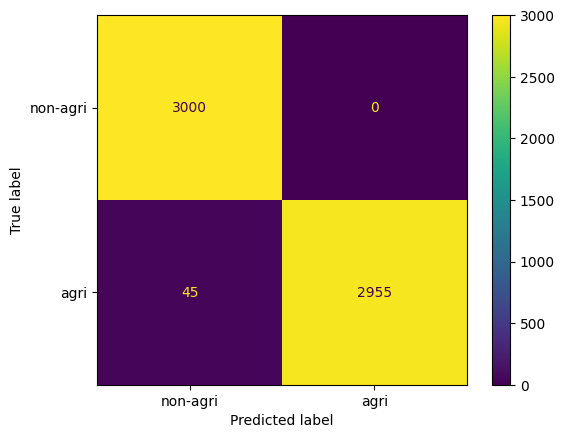

In [11]:
## Keras metrics reporting

print_metrics(y_true= all_labels_keras,
              y_pred= all_preds_keras,
              y_prob= all_probs_keras,
              class_labels=agri_class_labels,
              model_name= "keras Model"
              )

In [13]:
## PyTorch model evaluation and prediction

%%time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Processing inference on {device}")

train_transform = transforms.Compose([
    transforms.Resize((img_w, img_h)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)
test_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(),
    nn.MaxPool2d(2), nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
    nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
    nn.AdaptiveAvgPool2d(1), nn.Flatten(),
    nn.Linear(1024, 2048), nn.ReLU(), nn.BatchNorm1d(2048), nn.Dropout(0.4),
    nn.Linear(2048, num_classes)
).to(device)

print("Created model, now loading the weights from saved model state dict")
model.load_state_dict(torch.load(pytorch_state_dict_path))
print("Loaded model state dict, now getting predictions")

all_preds_pytorch = []
all_labels_pytorch = []
all_probs_pytorch = []


model.eval()
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Step")):
#    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        probs = F.softmax(outputs, dim=1)[:, 1]  # probability for class 1
        all_probs_pytorch.extend(probs.cpu())
        all_preds_pytorch.extend(preds.cpu().numpy().flatten())
        all_labels_pytorch.extend(labels.numpy())

Processing inference on cpu
Created model, now loading the weights from saved model state dict
Loaded model state dict, now getting predictions


Step: 100%|██████████| 47/47 [01:41<00:00,  2.16s/it]

CPU times: user 1min 20s, sys: 9.2 s, total: 1min 29s
Wall time: 1min 41s


Evaluation metrics for the PyTorch Model
Accuracy:  0.9988
ROC-AUC:   1.0000
Loss:      0.0024

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9993    0.9983    0.9988      3000
        agri     0.9983    0.9993    0.9988      3000

    accuracy                         0.9988      6000
   macro avg     0.9988    0.9988    0.9988      6000
weighted avg     0.9988    0.9988    0.9988      6000

========= Confusion Matrix =========


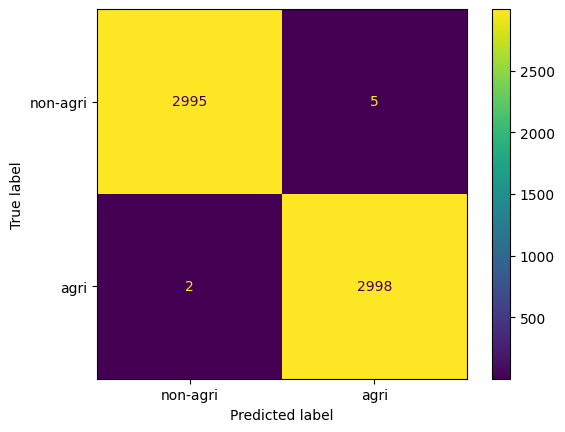

In [14]:
## PyTorch metrics reporting

print_metrics(y_true = all_labels_pytorch,
              y_pred = all_preds_pytorch,
              y_prob = all_probs_pytorch,
              class_labels = agri_class_labels,
              model_name = "PyTorch Model"
             )

In [17]:
## ROC curve plotting


def plot_roc(y_true, y_prob, model_name):
    n_classes = y_prob.shape[1] if y_prob.ndim > 1 else 1
    if n_classes == 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    else:
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            auc = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f'{model_name} class {i} (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()


In [18]:
# get the Keras model performance metrics
metrics_keras = model_metrics(all_labels_keras, all_preds_keras, all_probs_keras, agri_class_labels)

# get the PyTorch model performance metrics
metrics_pytorch = model_metrics(all_labels_pytorch, all_preds_pytorch, all_probs_pytorch, agri_class_labels)


# Display the comparison of metrics
print("{:<18} {:<15} {:<15}".format('\033[1m'+ 'Metric' + '\033[0m',
                                    'Keras Model',
                                    'PyTorch Model'))

mertics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for k in mertics_list:
    print("{:<18} {:<15.4f} {:<15.4f}".format('\033[1m'+k+'\033[0m',
                                              metrics_keras[k],
                                              metrics_pytorch[k]))

Metric     Keras Model     PyTorch Model  
Accuracy   0.9925          0.9988         
Precision  1.0000          0.9983         
Recall     0.9850          0.9993         
F1 Score   0.9924          0.9988         
ROC-AUC    1.0000          1.0000         
